In [14]:
import numpy as np
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as cp
    xp = cp
else:
    xp = np

from poppy.poppy_core import PlaneType

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display

import ray

from importlib import reload

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

import misc_funs as misc

from scoobpsf import scoobm, agpm
reload(scoobm)

poppy_log.disabled = True

pupil_diam = 6.75*u.mm
wavelength_c = 632.8e-9*u.m

dm_flat = fits.getdata(scoobm.module_path/'scoob_dm_flat.fits')

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, rotation=20)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3.6*u.mm/2, gray_pixel=False)

In [5]:
import os
pr_data = Path(os.path.dirname(str(scoobm.module_path)))/'phase-retrieval'

Could not find magpyx


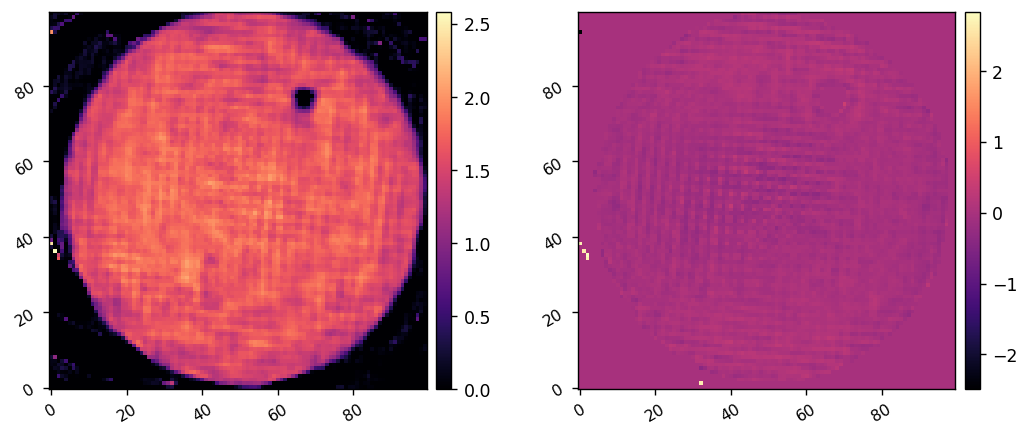

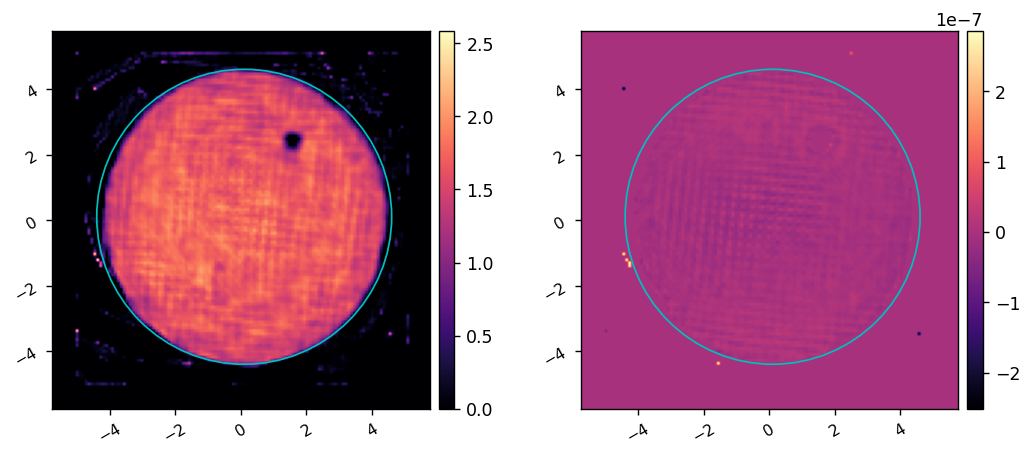

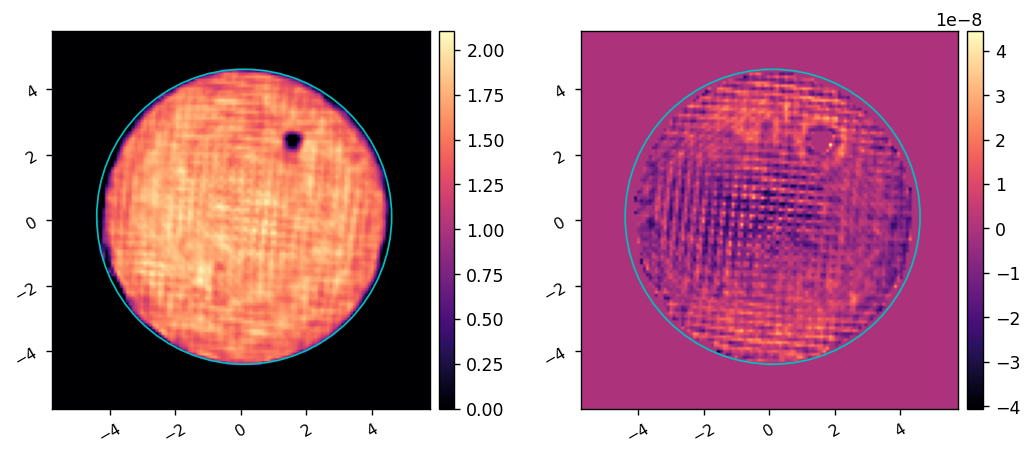

(65, 65)


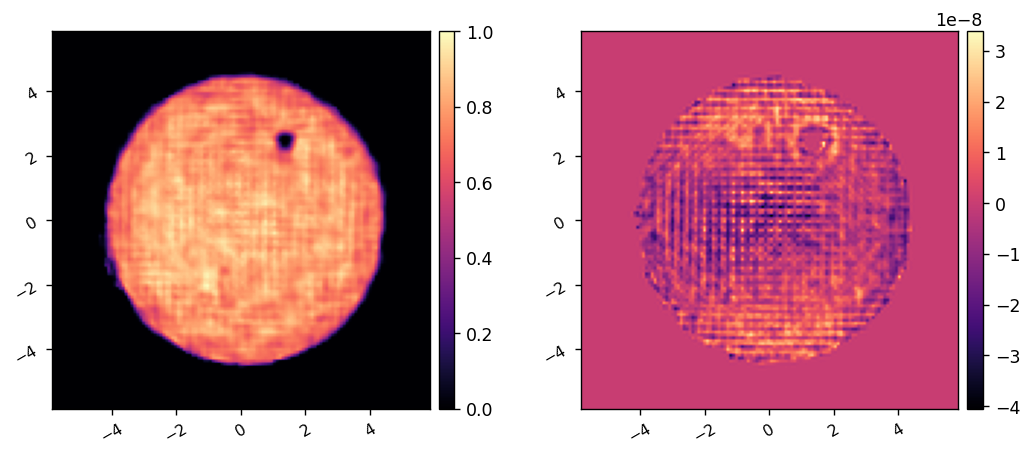

In [15]:
from wfsc import pr
reload(pr)
amp = np.flip(fits.getdata(pr_data/'pr_amp_20221207.fits'))
phase = np.flip(fits.getdata(pr_data/'pr_phase_20221207.fits'))
misc.imshow2(amp, phase, npix=100)

retrieved, pr_mask = pr.fix_pr_data(amp, phase, pupil_diam=9*u.mm, npix=100, 
                                    center=(0.1,0.1), angle=-5, return_mask=True, plot=True)


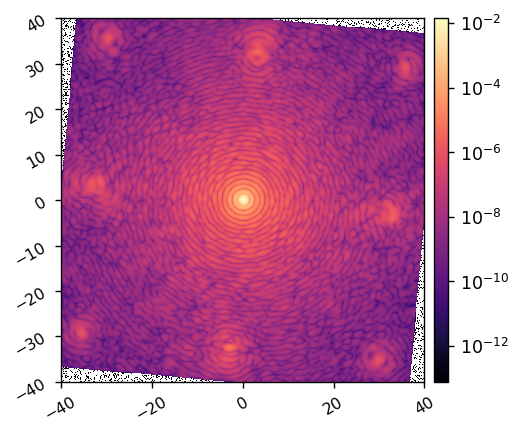

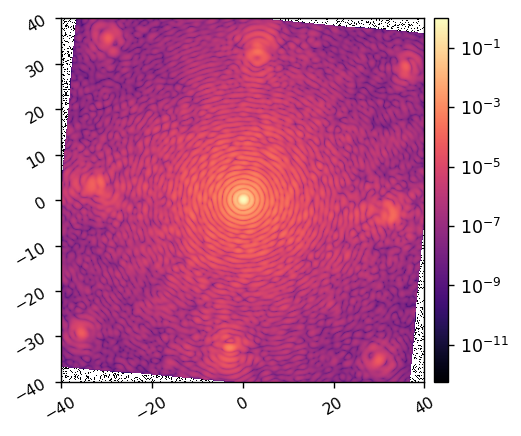

In [16]:
reload(scoobm)
model = scoobm.SCOOBM()

model.det_rotation = -5

# model.use_opds = True
# model.set_dm(dm_flat)
model.RETRIEVED = retrieved

ref_im = model.snap()
misc.imshow1(ref_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

model.imnorm = ref_im.max()

normalized_im = model.snap()
misc.imshow1(normalized_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

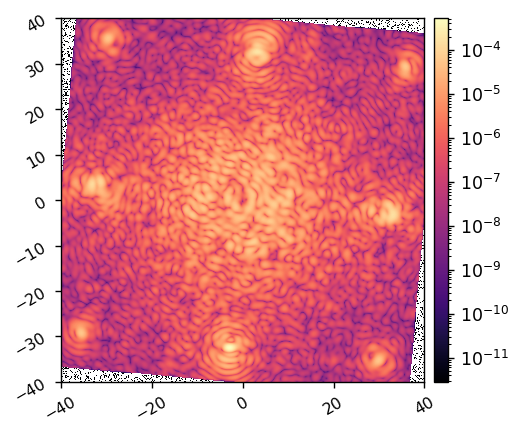

In [17]:
model.FPM = None
model.LYOT = None

model.FPM = vortex
model.LYOT = lyot_stop

im = model.snap()
misc.imshow1(im, lognorm=True, pxscl=model.psf_pixelscale_lamD)


In [21]:
reload(scoobm)
raySCOOB = ray.remote(scoobm.SCOOBM) # make a ray actor class from the original CGI class  

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

kwargs = {
    'RETRIEVED':retrieved,
    'FPM':vortex,
    'LYOT':lyot_stop,
    'imnorm':ref_im.max(),
    'det_rotation':-5,
}

actors = []
for i in range(nlam):
    actors.append(raySCOOB.options(num_gpus=1/nlam).remote(wavelength=wavelengths[i], **kwargs))

0.7858445644378662

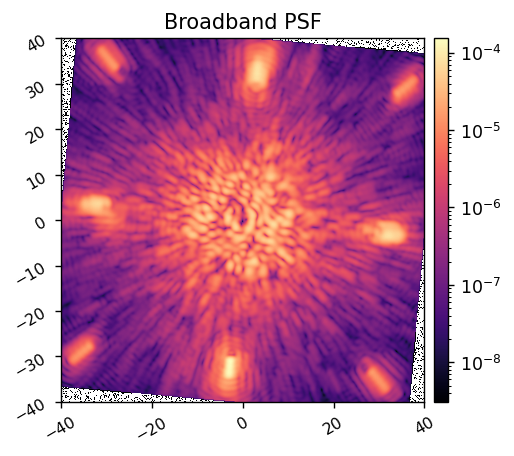

In [23]:
import time
start = time.time()
pending_ims = []
for i in range(len(actors)):
#     actors[i].set_dm.remote(dm_flat) # set the DM state for each actor in this loop
#     actors[i].setattr.remote('pupil_diam', 6.8*u.mm)
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = xp.array(ray.get(pending_ims))
clear_output()
display(time.time()-start)
psf_broad = xp.sum(ims, axis=0)/nlam

misc.imshow1(psf_broad, 'Broadband PSF', lognorm=True, pxscl=model.psf_pixelscale_lamD)
